In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import random
from PIL import Image,ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
df=pd.read_csv("_annotations.csv")

In [ ]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,image-8_png.rf.19740ac270c20dd97484e2ba8ed3087...,640,640,visual interference,237,441,393,555
1,image-21_png.rf.1517b03495ab63de44fdc7756d6ece...,640,640,visual interference,169,386,459,463
2,image-8_png.rf.1c062c29372861f2c326d7e1694735a...,640,640,visual interference,237,441,393,555
3,image-12_png.rf.4915b896c9acddb039a74261bc2736...,640,640,visual interference,473,493,640,636
4,imag-6_png.rf.47be18d1c5467958f5972c3859d63eb8...,640,640,visual interference,103,400,217,526


In [ ]:
df.drop(["width","height","class"],axis=1,inplace=True)

In [ ]:
unique_imgs=df.filename.unique()

In [ ]:
unique_imgs

array(['image-8_png.rf.19740ac270c20dd97484e2ba8ed3087f.jpg',
       'image-21_png.rf.1517b03495ab63de44fdc7756d6ece74.jpg',
       'image-8_png.rf.1c062c29372861f2c326d7e1694735aa.jpg',
       'image-12_png.rf.4915b896c9acddb039a74261bc2736a8.jpg',
       'imag-6_png.rf.47be18d1c5467958f5972c3859d63eb8.jpg',
       'image-20_png.rf.1c40ab80d9ce97ea6abc51ceddb10992.jpg',
       'image-7_png.rf.4f27f7119db523fad5f455bdf1857da2.jpg',
       'image-6_png.rf.6b073179e037f67efe95bf0291a7f480.jpg',
       'image-17_png.rf.35003bd3363412ea66503685f8e22edf.jpg',
       'image-21_png.rf.6c061d6ef2f6cd49787e48a0e87c3ce7.jpg',
       'image-7_png.rf.086df6a6af4108147bc4b13fa4568563.jpg',
       'image-20_png.rf.15756418f2287f1e6fa906c95d51c8f7.jpg',
       'image-18_png.rf.24028a5390c31e36f187878d3f4d7091.jpg',
       'image-4_png.rf.63d4396c05bec7c2cb15db6ebb612cc4.jpg',
       'image-24_png.rf.4705900c81f0629f19e4d291702d0fd4.jpg',
       'image-10_png.rf.3497711fe6f52895843d73800b81e17c.jpg',


In [ ]:
class CustDat(torch.utils.data.Dataset):
  def __init__(self, df, unique_imgs, indices):
    self.df=df
    self.unique_imgs =unique_imgs
    self.indices =indices
  def __len__ (self):
    return len(self.indices)
  def __getitem__ (self, idx):
    image_name= self.unique_imgs[self.indices[idx]]
    boxes = self.df[self.df.filename==image_name].values[:, 1:].astype("float")
    img = Image.open(image_name).convert('RGB')
    labels= torch.ones((boxes.shape[0]), dtype = torch.int64)
    target = {}
    target["boxes"] = torch.tensor (boxes)
    target["label"] = labels
    return T.ToTensor()(img), target

In [ ]:
train_inds , val_inds = train_test_split(range(unique_imgs.shape[0]) , test_size = 0.1)

In [ ]:
def custom_collate(data):
  return data

In [ ]:
train_dl = torch.utils.data.DataLoader(CustDat(df, unique_imgs, train_inds),batch_size = 16,shuffle= True,collate_fn=custom_collate,pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(CustDat(df, unique_imgs, val_inds),batch_size=8,shuffle=True,collate_fn=custom_collate, pin_memory = True if torch.cuda.is_available() else False)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 77.4MB/s]


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
optimizer=torch.optim.SGD(model.parameters() , lr = 0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 3

In [ ]:
model.to(device)
for epochs in range(num_epochs):
  epoch_loss = 0
  for data in train_dl:
    imgs = []
    targets = []
    for d in data:
      imgs.append(d[0].to(device))
      targ = {}
      targ["boxes"] = d[1]["boxes"].to(device)
      targ["labels"] = d[1] ["label"].to(device)
      targets.append(targ)
    loss_dict=model(imgs, targets)
    loss=sum(v for v in loss_dict.values())
    epoch_loss += loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(epoch_loss)

1.8288212364352032
0.8041578541362784
0.8143582211079793


In [ ]:
model.eval()
data=iter(val_dl).__next__()

In [ ]:
# img=data[0][0]
# boxes=data[0][1]["boxes"]
# labels=data[0][1]["label"]

In [ ]:
transform = T.Compose([ T.Resize((512, 512)),  T.ToTensor() ])

img = Image.open("image-3_png.rf.3c270c4b0d5e0ce05b3523641c706167.jpg")  # Load and convert to RGB
img = transform(img)

In [ ]:
output=model([img.to(device)])

In [ ]:
output

[{'boxes': tensor([[ 78.9004, 366.6202, 290.7186, 456.1034],
          [395.7282, 325.9189, 405.8358, 338.8235],
          [ 96.7196, 321.6483, 319.6937, 409.1877],
          [414.4931, 135.5744, 471.0543, 236.7910],
          [ 79.7938, 375.2950, 389.3855, 490.4378],
          [ 69.6667, 329.4593, 386.5822, 457.3044],
          [ 93.6180, 266.2159, 300.1473, 471.5903],
          [ 81.0213, 343.1632, 275.6518, 373.0190]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.0839, 0.0786, 0.0723, 0.0652, 0.0643, 0.0590, 0.0548, 0.0525],
         device='cuda:0', grad_fn=<IndexBackward0>)}]

In [ ]:
out_bbox=output[0]["boxes"]
out_scores=output[0]["scores"]

In [ ]:
keep=torchvision.ops.nms(out_bbox,out_scores,0.45)

In [ ]:
out_bbox.shape , keep.shape

(torch.Size([8, 4]), torch.Size([6]))

In [ ]:
im=(img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')

In [ ]:
vsample=Image.fromarray(im)

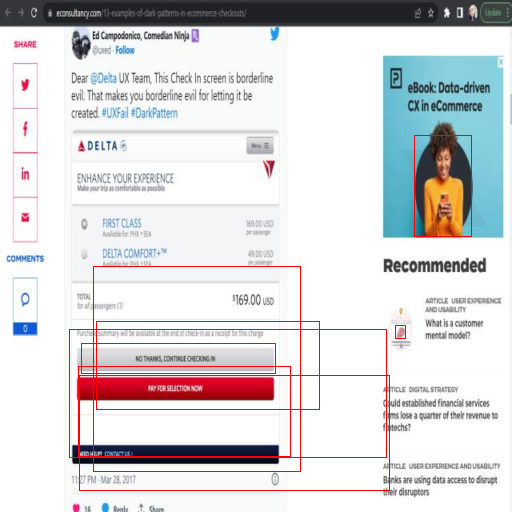

In [ ]:
draw=ImageDraw.Draw(vsample)
for box in out_bbox:
  draw.rectangle(list(box),fill=None,outline="red")
vsample